In [26]:
import tensorflow as tf
from tensorflow.keras.layers import *

In [27]:
description='MoCo example: MNIST'
batchsize=100
epochs =50

class DuplicatedCompose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        return self.transforms(img), self.transforms(img)

In [28]:
class RandomResizedCrop(tf.keras.layers.Layer):
    # taken from
    # https://keras.io/examples/vision/nnclr/#random-resized-crops
    def __init__(self, scale, ratio, crop_shape):
        super(RandomResizedCrop, self).__init__()
        self.scale = scale
        self.log_ratio = (tf.math.log(ratio[0]), tf.math.log(ratio[1]))
        self.crop_shape = crop_shape

    def call(self, images):
        batch_size = tf.shape(images)[0]

        random_scales = tf.random.uniform(
            (batch_size,),
            self.scale[0],
            self.scale[1]
        )
        random_ratios = tf.exp(tf.random.uniform(
            (batch_size,),
            self.log_ratio[0],
            self.log_ratio[1]
        ))

        new_heights = tf.clip_by_value(
            tf.sqrt(random_scales / random_ratios),
            0,
            1,
        )
        new_widths = tf.clip_by_value(
            tf.sqrt(random_scales * random_ratios),
            0,
            1,
        )
        height_offsets = tf.random.uniform(
            (batch_size,),
            0,
            1 - new_heights,
        )
        width_offsets = tf.random.uniform(
            (batch_size,),
            0,
            1 - new_widths,
        )

        bounding_boxes = tf.stack(
            [
                height_offsets,
                width_offsets,
                height_offsets + new_heights,
                width_offsets + new_widths,
            ],
            axis=1,
        )
        images = tf.image.crop_and_resize(
            images,
            bounding_boxes,
            tf.range(batch_size),
            self.crop_shape,
        )
        return images

In [29]:
transform = DuplicatedCompose(tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.05,'constant'),
    RandomResizedCrop(scale=(0.9, 1.1), ratio=(0.9, 1.1),crop_shape=(28,28)),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
]))


In [30]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [31]:
x_train = tf.reshape(x_train,(x_train.shape[0],x_train.shape[1],x_train.shape[2],1))
x_test = tf.reshape(x_test,(x_test.shape[0],x_test.shape[1],x_test.shape[2],1))

In [32]:
train_mnist = tf.data.Dataset.from_tensor_slices((x_train,y_train))
test_mnist = tf.data.Dataset.from_tensor_slices((x_test,y_test))

In [33]:
train_loader = train_mnist.batch(batchsize)
test_loader = test_mnist.batch(batchsize)

In [34]:
def normalize(x,eps = 1e-4):
    return x/tf.reshape(tf.math.maximum(tf.reduce_sum(x**2,axis = -1),eps),(-1,1))
def build_model():
    inputs = Input((28,28,1))
    x = Conv2D(32,3,activation = 'relu')(inputs)
    x = Conv2D(64,3,activation = 'relu')(x)
    x = MaxPooling2D(2)(x)
    x = Flatten()(x)
    x = Dense(128)(x)
    x = normalize(x)
    model = tf.keras.Model(inputs,x)
    return model

In [35]:
model_q = build_model()
model_k = tf.keras.models.clone_model(model_q)
optimizer = tf.keras.optimizers.SGD()

In [36]:
def queue_data(data, k):
    return tf.concat([data, k], axis=0)
def dequeue_data(data, K=4096):
    if len(data) > K:
        return data[-K:]
    else:
        return data
def initialize_queue(model_k, train_loader):
    queue = tf.zeros((0, 128), dtype=tf.float32) 
    
    for batch_idx, (data, target) in enumerate(train_loader):
        x_k = transform(data)[0]
        k = model_k(x_k)
        k = tf.stop_gradient(k)
        queue = queue_data(queue, k)
        queue = dequeue_data(queue, K = 10)
        break
    return queue

queue = initialize_queue(model_k, train_loader)

In [37]:
def momentum_update(model_q, model_k, beta = 0.999):
    for i in range(len(model_q.layers)):
        if len(model_q.layers[i].get_weights())>0:
            w_q_i = model_q.layers[i].get_weights()[0]
            w_k_i = model_k.layers[i].get_weights()[0]
            b_q_i = model_q.layers[i].get_weights()[1]
            b_k_i = model_k.layers[i].get_weights()[1]
            model_k.layers[i].set_weights([beta*w_k_i + (1-beta)*w_q_i,beta*b_k_i + (1-beta)*b_q_i])

In [38]:
class MOCO(tf.keras.Model):
    def __init__(self, model_q):
      super(MOCO, self).__init__()
      self.model_q = model_q
      self.model_k = tf.keras.models.clone_model(model_q)
      self.queue = initialize_queue(model_k, train_loader)
      self.temp = 0.07
    def compile(self, optimizer, loss_fn):
        super(MOCO, self).compile(run_eagerly=True)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
      
    def train_step(self, data_):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        data, target = data_
        x_q,x_k = transform(data)
        k = model_k(x_k)
        k = tf.stop_gradient(k)
        N = tf.shape(data)[0]
        K = tf.shape(self.queue)[0]
        with tf.GradientTape() as tape:
            q = model_q(x_q)
            a = tf.reshape(q,(N,1,-1))
            b = tf.reshape(k,(N,-1,1))
            l_pos = tf.matmul(a,b)
            l_neg = tf.matmul(tf.reshape(q,(N,-1)), tf.reshape(tf.transpose(self.queue),(-1,K)))
            logits = tf.concat([tf.reshape(l_pos,(N, 1)), l_neg], axis=1)
            labels = tf.zeros(N, dtype=tf.float32)
            loss = self.loss_fn(labels,logits/self.temp)
        grads = tape.gradient(loss, model_q.trainable_weights)
        optimizer.apply_gradients(zip(grads, model_q.trainable_weights))

        momentum_update(self.model_q, self.model_k)

        queue = queue_data(self.queue, k)
        queue = dequeue_data(self.queue)

        return {"loss": loss}

In [39]:
moco = MOCO(model_q)

In [40]:
moco.compile(optimizer, tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [41]:
moco.fit(train_loader,epochs = epochs)

Epoch 1/50
600/600 [==============================] - 39s 65ms/step - loss: 0.5174
Epoch 2/50
600/600 [==============================] - 39s 64ms/step - loss: 0.0060
Epoch 3/50
600/600 [==============================] - 39s 66ms/step - loss: 0.3148
Epoch 4/50
600/600 [==============================] - 39s 65ms/step - loss: 0.0627
Epoch 5/50
600/600 [==============================] - 39s 65ms/step - loss: 0.0049
Epoch 6/50
600/600 [==============================] - 39s 65ms/step - loss: 0.0019
Epoch 7/50
600/600 [==============================] - 39s 65ms/step - loss: 0.2412
Epoch 8/50
600/600 [==============================] - 40s 66ms/step - loss: 0.0103
Epoch 9/50
600/600 [==============================] - 40s 67ms/step - loss: 0.0774
Epoch 10/50
600/600 [==============================] - 39s 65ms/step - loss: 0.0158
Epoch 11/50
600/600 [==============================] - 40s 66ms/step - loss: 0.0022
Epoch 12/50
600/600 [==============================] - 39s 65ms/step - loss: 0.0155
E

In [42]:
from sklearn.manifold import TSNE

In [43]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np

In [45]:
from tqdm.notebook import tqdm
data = []
targets = []
for m in tqdm(test_mnist):
    target = m[1]
    targets.append(target)
    x = m[0]
    x = tf.reshape(x,(1, 28,28))/255
    feat = model_q(x)
    data.append(feat.numpy()[0])

  0%|          | 0/10000 [00:00<?, ?it/s]

In [46]:
ret = TSNE(n_components=2, random_state=0).fit_transform(data)

In [47]:
def show(mnist, targets, ret):
    target_ids = range(len(set(targets)))
    
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'violet', 'orange', 'purple']
    
    plt.figure(figsize=(12, 10))
    
    ax = plt.subplot(aspect='equal')
    for label in set(targets):
        idx = np.where(np.array(targets) == label)[0]
        plt.scatter(ret[idx, 0], ret[idx, 1], c=colors[label], label=label)
    
    for i in range(0, len(targets), 250):
        img = (x_test[i,:,:,0] * 255)
        img = OffsetImage(img, cmap=plt.cm.gray_r, zoom=0.5) 
        ax.add_artist(AnnotationBbox(img, ret[i]))
    
    plt.legend()
    plt.show()

In [48]:
targets = [element.numpy() for element in targets]

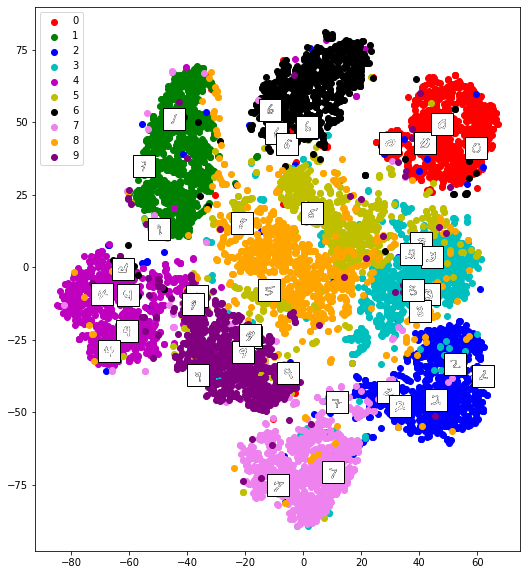

In [49]:
show(mnist, targets, ret)